In [1]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
# 필요한 라이브러리 로드

import emoji
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import torch
from communav.utils import db
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from soynlp.normalizer import repeat_normalize
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

/tmp/ipykernel_17996/2000937440.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 카테고리 정의

CATEGORIES = {
    0: '자유',
    1: '학사',
    2: '장학 · 행정',
    3: '학교생활',
    4: '수업',
    5: '수업/이과',
    6: '수업/문과',
    7: '캠퍼스',
    8: '취업 · 진로',
    9: '일상생활',
    10: '음식점 · 카페',
    11: '취미 · 여가',
    12: '인간관계',
    13: '병역'
}

In [4]:
# 파라미터 설정

TABLE_NAME = 'everytime_article_dataset_v1'
MODEL_ID = 'beomi/KcELECTRA-base-v2022'
TOKENIZER_ID = 'beomi/KcELECTRA-base-v2022'
SEED = 42
NUM_LABELS = len(CATEGORIES)
MAX_LENGTH = 128
METRIC_AVERAGE = 'weighted'
METRIC_ZERO_DIVISION = 0
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 2e-5
SAVE_PATH = '.'

In [5]:
# 랜덤 시드 고정

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


In [6]:
# 커뮤니티 게시글 데이터 로드

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute(f'''
    SELECT id, title, text, category_id
    FROM {TABLE_NAME}
    WHERE category_id IS NOT NULL
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')

cursor.close()
db.close_connection()

Connected to DB successfully.
Loaded 4094 articles.


In [7]:
# 가져온 데이터의 일부를 출력

for article in original_articles[:20]:
    print(article)

{'id': 1, 'title': '어제 비마관 화장실에서 핸드폰 찾아주신분!', 'text': '제가 경황이 없어서 감사하다고도 못 했네요.\n정말 감사합니다!!!', 'category_id': 9}
{'id': 3, 'title': '조은문화사 몇시에 보통 열리나요??', 'text': '1교시 수업 책 찾아야되서', 'category_id': 7}
{'id': 4, 'title': '전공수업듣는데', 'text': '복학한거처럼 보이는 형이 열심히는 하시던데 뭔가 군대갔다고오고 모든걸 까먹은 자기를 자책하듯이 수업듣는걸 보고 나도 3년후에 저러겠구나 싶더라... ㅠㅠ', 'category_id': 4}
{'id': 5, 'title': '정문에 있는 인쇄집들 몇시까지 하는지 아시나요?', 'text': '9시 넘어야 갈수있을거 같은데\n열어 있을지..', 'category_id': 7}
{'id': 8, 'title': '문화유목시대 교재뭔가요', 'text': '정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?', 'category_id': 6}
{'id': 13, 'title': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;;', 'text': '이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가?\n왜 일자로만 나와....', 'category_id': 5}
{'id': 14, 'title': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;;', 'text': '이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가?\n왜 일자로만 나와....\n이건 회로인데 뭐가 잘못된거지요????;;', 'category_id': 5}
{'id': 17, 'title': '컴퓨터구조 책삽니다', 'text': '표지에 컴퓨터구조 및 설계 써있고 5판 한글판 중고 2만원에삽니다\nPatterson , Hennessy 저자 입니다', 'category_

In [8]:
# 데이터 전처리 함수 정의

normal_pattern = re.compile(r'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def preprocess(value):
    value = normal_pattern.sub(' ', value)
    value = emoji.replace_emoji(value, replace='')
    value = url_pattern.sub('', value)
    value = repeat_normalize(value, num_repeats=2)
    value = value.strip()
    return value

In [9]:
# 데이터 전처리

preprocessed_articles = []

for article in tqdm(original_articles):
    title = article['title']
    text = article['text']
    content = (title + ' ' + text).replace('\n', ' ')

    preprocessed_articles.append({
        'content': preprocess(content),
        'label': article['category_id']
    })

100%|██████████| 4094/4094 [00:00<00:00, 18051.83it/s]


In [10]:
# 전처리된 데이터의 일부를 출력

for article in preprocessed_articles[:20]:
    print(article)

{'content': '어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!', 'label': 9}
{'content': '조은문화사 몇시에 보통 열리나요?? 1교시 수업 책 찾아야되서', 'label': 7}
{'content': '전공수업듣는데 복학한거처럼 보이는 형이 열심히는 하시던데 뭔가 군대갔다고오고 모든걸 까먹은 자기를 자책하듯이 수업듣는걸 보고 나도 3년후에 저러겠구나 싶더라... ㅠㅠ', 'label': 4}
{'content': '정문에 있는 인쇄집들 몇시까지 하는지 아시나요? 9시 넘어야 갈수있을거 같은데 열어 있을지..', 'label': 7}
{'content': '문화유목시대 교재뭔가요 정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?', 'label': 6}
{'content': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와....', 'label': 5}
{'content': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와.... 이건 회로인데 뭐가 잘못된거지요????;;', 'label': 5}
{'content': '컴퓨터구조 책삽니다 표지에 컴퓨터구조 및 설계 써있고 5판 한글판 중고 2만원에삽니다 Patterson , Hennessy 저자 입니다', 'label': 5}
{'content': '오늘 영화의 이해 수업 영화의 이해 유양근 교수님 수업을 못가서 그런데 혹시 교재같은거나 해오라고 하신거 있나요?! ㅜㅜ', 'label': 6}
{'content': '초급일본어 전유나 초급일본어 책필요한가요?', 'label': 6}
{'content': '졸업학점있잖아 교양 30 전공 60 선택50 이면 무조건 저거

In [11]:
# 데이터 분포 확인 함수 정의

def plot_distribution(articles):
    label_counts = {category_id: 0 for category_id in CATEGORIES}
    for article in articles:
        label_counts[article['label']] += 1

    total_count = sum(label_counts.values())
    percentages = {category_id: count / total_count * 100 for category_id, count in label_counts.items()}
    for category_id, percentage in percentages.items():
        print(f'{CATEGORIES[category_id]} [{category_id}]: {percentage:.2f}%')

    plt.figure(figsize=(12, 8))
    plt.bar(CATEGORIES.keys(), label_counts.values())
    for i, count in enumerate(label_counts.values()):
        plt.text(i, count + 0.1, str(count), ha='center')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Distribution of Categories')
    plt.xticks(range(len(CATEGORIES)), list(CATEGORIES.keys()))
    plt.tight_layout()
    plt.show()

자유 [0]: 9.55%
학사 [1]: 6.64%
장학 · 행정 [2]: 21.81%
학교생활 [3]: 7.65%
수업 [4]: 4.20%
수업/이과 [5]: 10.50%
수업/문과 [6]: 6.72%
캠퍼스 [7]: 7.01%
취업 · 진로 [8]: 3.57%
일상생활 [9]: 6.79%
음식점 · 카페 [10]: 4.91%
취미 · 여가 [11]: 4.30%
인간관계 [12]: 2.56%
병역 [13]: 3.79%


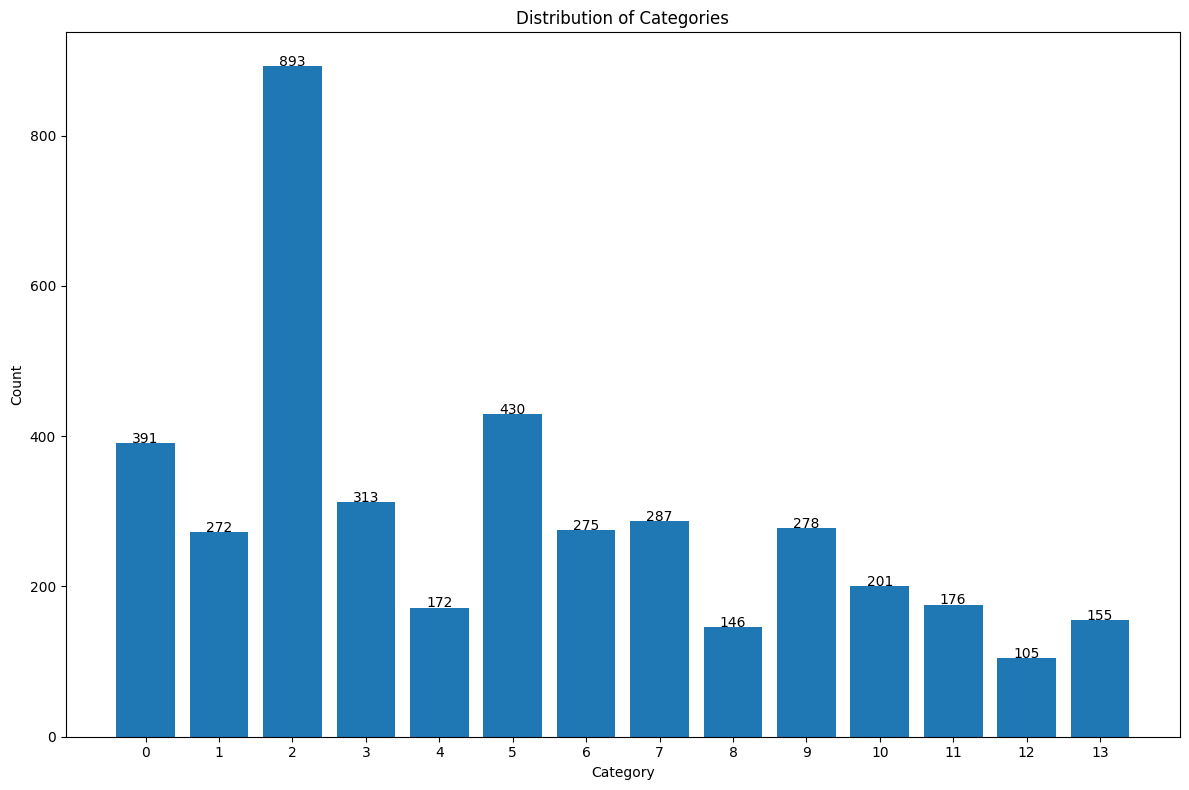

In [12]:
# 데이터 분포 확인

plot_distribution(preprocessed_articles)

In [13]:
# 훈련 데이터와 검증 데이터로 분리

train_articles, val_articles = train_test_split(
    preprocessed_articles,
    test_size=0.2,
    random_state=SEED
)

print(f'Number of training articles: {len(train_articles)}')
print(f'Number of validation articles: {len(val_articles)}')

Number of training articles: 3275
Number of validation articles: 819


자유 [0]: 9.74%
학사 [1]: 6.81%
장학 · 행정 [2]: 21.71%
학교생활 [3]: 7.82%
수업 [4]: 4.37%
수업/이과 [5]: 10.23%
수업/문과 [6]: 7.42%
캠퍼스 [7]: 7.08%
취업 · 진로 [8]: 3.54%
일상생활 [9]: 6.29%
음식점 · 카페 [10]: 4.70%
취미 · 여가 [11]: 3.85%
인간관계 [12]: 2.56%
병역 [13]: 3.88%


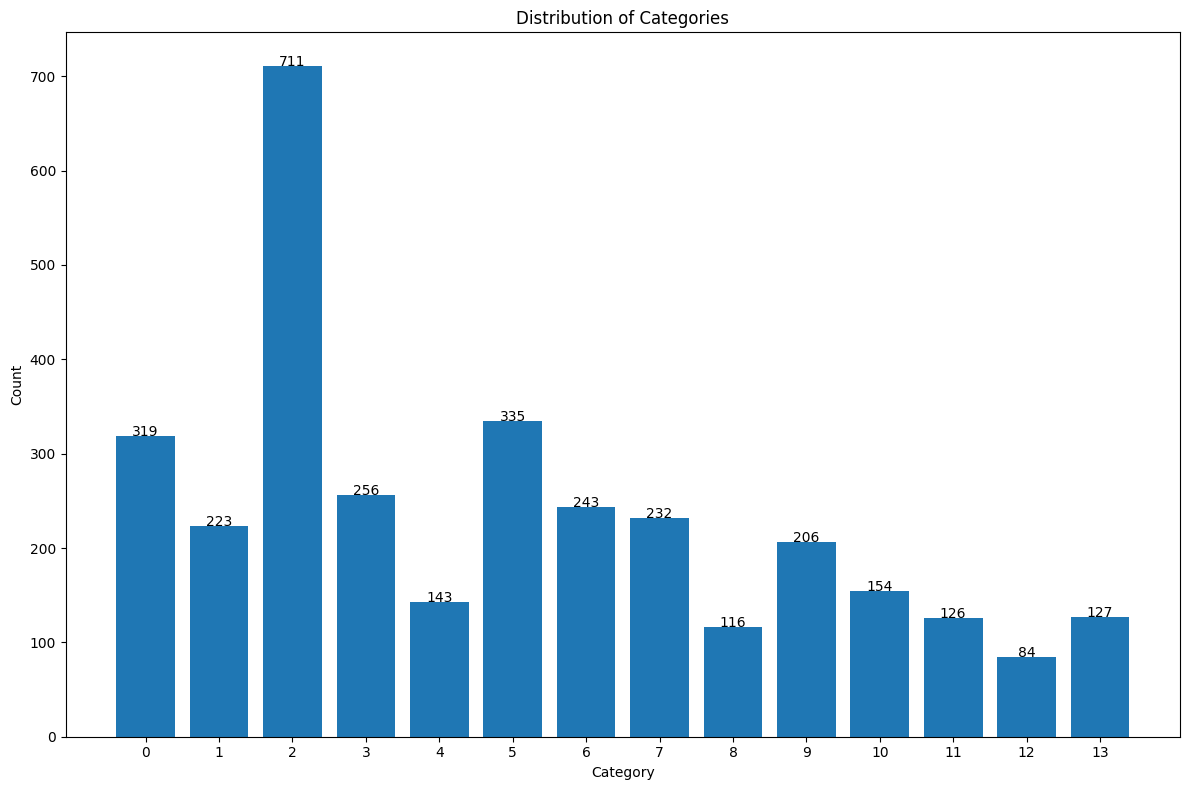

In [14]:
# 훈련 데이터의 데이터 분포 확인

plot_distribution(train_articles)

자유 [0]: 8.79%
학사 [1]: 5.98%
장학 · 행정 [2]: 22.22%
학교생활 [3]: 6.96%
수업 [4]: 3.54%
수업/이과 [5]: 11.60%
수업/문과 [6]: 3.91%
캠퍼스 [7]: 6.72%
취업 · 진로 [8]: 3.66%
일상생활 [9]: 8.79%
음식점 · 카페 [10]: 5.74%
취미 · 여가 [11]: 6.11%
인간관계 [12]: 2.56%
병역 [13]: 3.42%


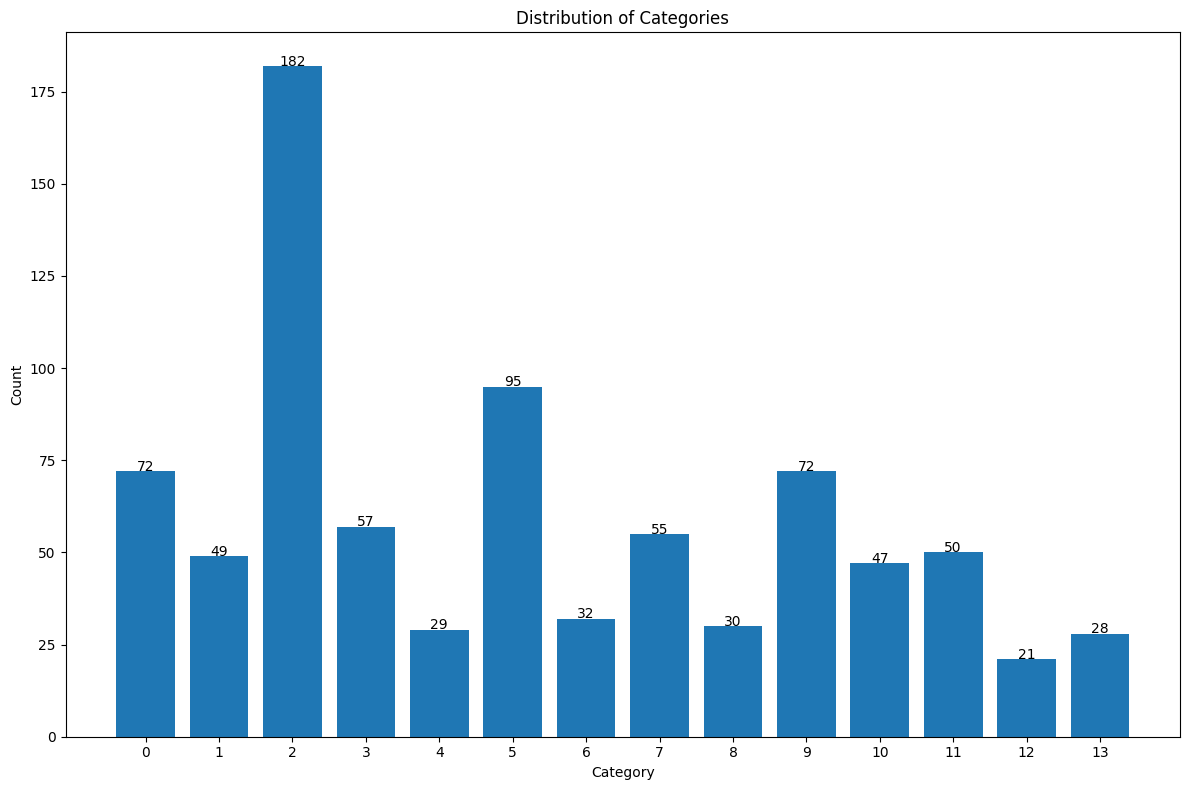

In [15]:
# 검증 데이터의 데이터 분포 확인

plot_distribution(val_articles)

In [16]:
# 토크나이저 로드

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_ID, do_basic_tokenize=False)

print('Original:', preprocessed_articles[0]['content'])
print('Tokenized:', tokenizer.tokenize(preprocessed_articles[0]['content']))

Original: 어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!
Tokenized: ['어제', '비', '##마', '##관', '화장실', '##에서', '핸드폰', '찾아', '##주신', '##분', '!', '제가', '경', '##황', '##이', '없어서', '감사', '##하다고', '##도', '못', '했네요', '.', '정말', '감사합니다', '!', '!', '!']


In [17]:
# 모델 로드

model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=NUM_LABELS)
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [18]:
# 모델 세부 정보 수정

model.resize_token_embeddings(len(tokenizer))

Embedding(54343, 768, padding_idx=0)

In [19]:
# 텍스트 인코딩 및 데이터셋 생성

train_contents = [article['content'] for article in train_articles]
train_labels = [article['label'] for article in train_articles]
val_contents = [article['content'] for article in val_articles]
val_labels = [article['label'] for article in val_articles]

train_encodings = tokenizer(
    train_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
val_encodings = tokenizer(
    val_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipykernel_17996/2848816050.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['input_ids']),
/tmp/ipykernel_17996/2848816050.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
/tmp/ipykernel_17996/2848816050.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
/tmp/ipykernel_17996/2848816050.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

In [20]:
# 학습 전 초기화

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataset) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_accs = []
train_precs = []
train_recs = []
train_f1s = []
train_losses = []

val_accs = []
val_precs = []
val_recs = []
val_f1s = []
val_losses = []

In [21]:
# 평가 지표 계산 함수 정의

def calculate_metrics(true_labels, predicted_labels):
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    rec = recall_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    f_beta = f1_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)

    return acc, prec, rec, f_beta

In [22]:
# 학습 시작

best_val_f1 = 0.0
best_model_path = None

for epoch in range(EPOCHS):
    model.train()

    train_loss = 0.0
    train_predictions = []
    train_labels_epoch = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1} - Training'):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        train_predictions.extend(predictions.tolist())
        train_labels_epoch.extend(labels.tolist())

    train_acc, train_prec, train_rec, train_f1 = calculate_metrics(train_labels_epoch, train_predictions)
    train_accs.append(train_acc)
    train_precs.append(train_prec)
    train_recs.append(train_rec)
    train_f1s.append(train_f1)
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()

    val_loss = 0.0
    val_predictions = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Epoch {epoch + 1} - Validation'):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            val_predictions.extend(predictions.tolist())

    val_acc, val_prec, val_rec, val_f1 = calculate_metrics(val_labels, val_predictions)
    val_accs.append(val_acc)
    val_precs.append(val_prec)
    val_recs.append(val_rec)
    val_f1s.append(val_f1)
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Acc = {train_acc:.4f}, Train Prec = {train_prec:.4f}, Train Rec = {train_rec:.4f}, Train F1 = {train_f1:.4f}, Train Loss = {train_loss:.4f}')
    print(f'  Val Acc = {val_acc:.4f}, Val Prec = {val_prec:.4f}, Val Rec = {val_rec:.4f}, Val F1 = {val_f1:.4f}, Val Loss = {val_loss:.4f}')

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_path = os.path.join(SAVE_PATH, f'.model-epoch-{epoch + 1:02d}-{best_val_f1:.4f}')
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f'  Best model saved with {best_val_f1:.4f} F1 score.')

print('Training finished.')

Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Epoch 1:
  Train Acc = 0.2788, Train Prec = 0.1749, Train Rec = 0.2788, Train F1 = 0.1692, Train Loss = 2.2953
  Val Acc = 0.4408, Val Prec = 0.3545, Val Rec = 0.4408, Val F1 = 0.3367, Val Loss = 1.7712
  Best model saved with 0.3367 F1 score.


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.67it/s]


Epoch 2:
  Train Acc = 0.6186, Train Prec = 0.6629, Train Rec = 0.6186, Train F1 = 0.5467, Train Loss = 1.3822
  Val Acc = 0.7302, Val Prec = 0.7274, Val Rec = 0.7302, Val F1 = 0.6716, Val Loss = 0.9431
  Best model saved with 0.6716 F1 score.


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Epoch 3:
  Train Acc = 0.8495, Train Prec = 0.8647, Train Rec = 0.8495, Train F1 = 0.8278, Train Loss = 0.6930
  Val Acc = 0.8962, Val Prec = 0.9053, Val Rec = 0.8962, Val F1 = 0.8907, Val Loss = 0.4825
  Best model saved with 0.8907 F1 score.


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.76it/s]


Epoch 4:
  Train Acc = 0.9521, Train Prec = 0.9542, Train Rec = 0.9521, Train F1 = 0.9515, Train Loss = 0.3203
  Val Acc = 0.9292, Val Prec = 0.9313, Val Rec = 0.9292, Val F1 = 0.9289, Val Loss = 0.3325
  Best model saved with 0.9289 F1 score.


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.92it/s]


Epoch 5:
  Train Acc = 0.9795, Train Prec = 0.9796, Train Rec = 0.9795, Train F1 = 0.9795, Train Loss = 0.1692
  Val Acc = 0.9341, Val Prec = 0.9366, Val Rec = 0.9341, Val F1 = 0.9337, Val Loss = 0.2702
  Best model saved with 0.9337 F1 score.


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.88it/s]


Epoch 6:
  Train Acc = 0.9863, Train Prec = 0.9863, Train Rec = 0.9863, Train F1 = 0.9863, Train Loss = 0.1017
  Val Acc = 0.9365, Val Prec = 0.9380, Val Rec = 0.9365, Val F1 = 0.9361, Val Loss = 0.2603
  Best model saved with 0.9361 F1 score.


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.07it/s]


Epoch 7:
  Train Acc = 0.9915, Train Prec = 0.9915, Train Rec = 0.9915, Train F1 = 0.9914, Train Loss = 0.0667
  Val Acc = 0.9377, Val Prec = 0.9409, Val Rec = 0.9377, Val F1 = 0.9375, Val Loss = 0.2790
  Best model saved with 0.9375 F1 score.


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.05it/s]


Epoch 8:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F1 = 0.9954, Train Loss = 0.0418
  Val Acc = 0.9487, Val Prec = 0.9492, Val Rec = 0.9487, Val F1 = 0.9485, Val Loss = 0.2605
  Best model saved with 0.9485 F1 score.


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.02it/s]


Epoch 9:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F1 = 0.9963, Train Loss = 0.0331
  Val Acc = 0.9536, Val Prec = 0.9550, Val Rec = 0.9536, Val F1 = 0.9536, Val Loss = 0.2479
  Best model saved with 0.9536 F1 score.


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Epoch 10:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F1 = 0.9924, Train Loss = 0.0396
  Val Acc = 0.9365, Val Prec = 0.9396, Val Rec = 0.9365, Val F1 = 0.9361, Val Loss = 0.3072


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.03it/s]


Epoch 11:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F1 = 0.9927, Train Loss = 0.0396
  Val Acc = 0.9487, Val Prec = 0.9505, Val Rec = 0.9487, Val F1 = 0.9487, Val Loss = 0.2755


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.07it/s]


Epoch 12:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F1 = 0.9927, Train Loss = 0.0356
  Val Acc = 0.9487, Val Prec = 0.9505, Val Rec = 0.9487, Val F1 = 0.9487, Val Loss = 0.2770


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.03it/s]


Epoch 13:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F1 = 0.9985, Train Loss = 0.0164
  Val Acc = 0.9560, Val Prec = 0.9581, Val Rec = 0.9560, Val F1 = 0.9559, Val Loss = 0.2521
  Best model saved with 0.9559 F1 score.


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.11it/s]


Epoch 14:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F1 = 0.9988, Train Loss = 0.0123
  Val Acc = 0.9463, Val Prec = 0.9487, Val Rec = 0.9463, Val F1 = 0.9464, Val Loss = 0.2988


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.99it/s]


Epoch 15:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F1 = 0.9982, Train Loss = 0.0125
  Val Acc = 0.9475, Val Prec = 0.9503, Val Rec = 0.9475, Val F1 = 0.9479, Val Loss = 0.2947


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.00it/s]


Epoch 16:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F1 = 0.9991, Train Loss = 0.0093
  Val Acc = 0.9499, Val Prec = 0.9512, Val Rec = 0.9499, Val F1 = 0.9497, Val Loss = 0.2982


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.96it/s]


Epoch 17:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F1 = 0.9957, Train Loss = 0.0181
  Val Acc = 0.9451, Val Prec = 0.9498, Val Rec = 0.9451, Val F1 = 0.9447, Val Loss = 0.3485


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.91it/s]


Epoch 18:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F1 = 0.9948, Train Loss = 0.0218
  Val Acc = 0.9426, Val Prec = 0.9468, Val Rec = 0.9426, Val F1 = 0.9430, Val Loss = 0.3381


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.01it/s]


Epoch 19:
  Train Acc = 0.9954, Train Prec = 0.9955, Train Rec = 0.9954, Train F1 = 0.9954, Train Loss = 0.0239
  Val Acc = 0.9426, Val Prec = 0.9484, Val Rec = 0.9426, Val F1 = 0.9432, Val Loss = 0.3587


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.14it/s]


Epoch 20:
  Train Acc = 0.9933, Train Prec = 0.9933, Train Rec = 0.9933, Train F1 = 0.9933, Train Loss = 0.0325
  Val Acc = 0.9573, Val Prec = 0.9582, Val Rec = 0.9573, Val F1 = 0.9571, Val Loss = 0.2749
  Best model saved with 0.9571 F1 score.
Training finished.


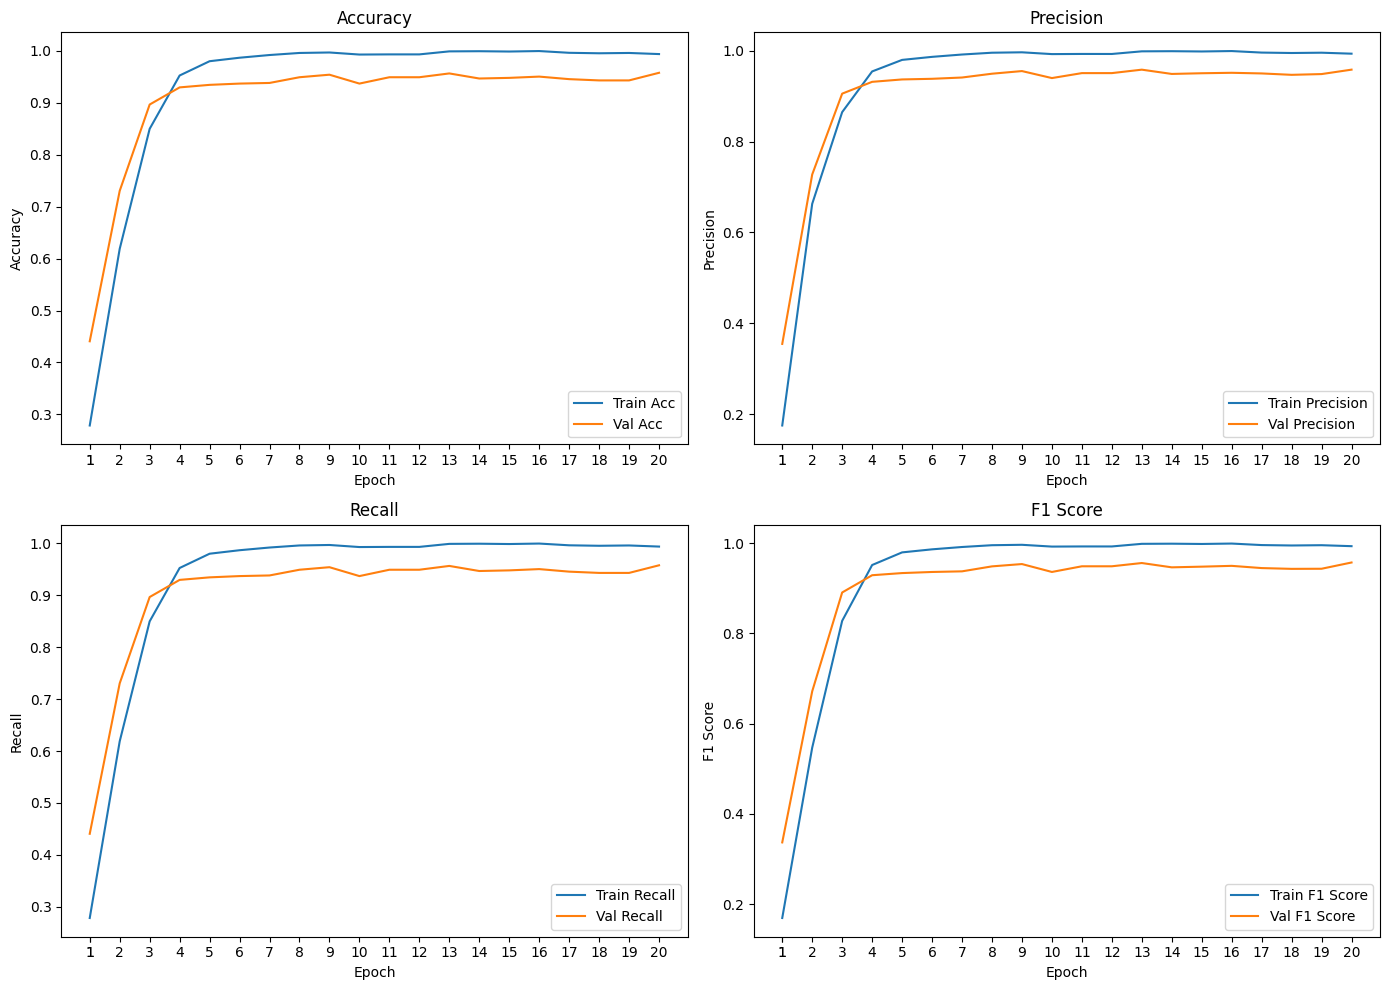

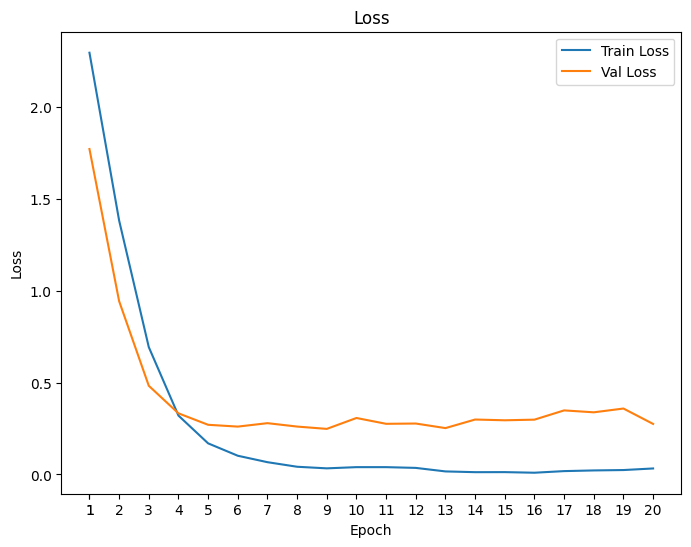

In [23]:
# 학습 결과 시각화

if EPOCHS <= 20:
    step = 1
elif EPOCHS <= 50:
    step = 5
elif EPOCHS <= 100:
    step = 10
else:
    step = 20

epochs = range(1, EPOCHS + 1)
tick_marks = [1] + list(range(step, EPOCHS + 1, step))

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs, train_precs, label='Train Precision')
plt.plot(epochs, val_precs, label='Val Precision')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

plt.subplot(2, 2, 3)
plt.plot(epochs, train_recs, label='Train Recall')
plt.plot(epochs, val_recs, label='Val Recall')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1s, label='Train F1 Score')
plt.plot(epochs, val_f1s, label='Val F1 Score')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [24]:
# 평가

print(f'Best model path: {best_model_path}')
print()

model = AutoModelForSequenceClassification.from_pretrained(best_model_path, num_labels=NUM_LABELS)
model.to(device)

with open('../test-dataset.json', 'r', encoding='utf-8') as f:
    test_articles = json.load(f)

test_contents = [preprocess(article['content']) for article in test_articles]
test_labels = [article['label'] for article in test_articles]

test_encodings = tokenizer(
    test_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
test_input_ids = test_encodings['input_ids'].to(device)
test_attention_mask = test_encodings['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(test_input_ids, attention_mask=test_attention_mask)
    logits = outputs.logits
    test_predictions = torch.argmax(logits, dim=1).tolist()
    test_probabilities = torch.softmax(logits, dim=1).tolist()

test_acc, test_prec, test_rec, test_f1 = calculate_metrics(test_labels, test_predictions)

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_prec:.4f}')
print(f'Test Recall: {test_rec:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print()

for content, label, prediction, probs in zip(test_contents, test_labels, test_predictions, test_probabilities):
    true_category = CATEGORIES[label]
    predicted_category = CATEGORIES[prediction]
    probs_formatted = [f'{prob:.4f}' for prob in probs]

    print(f'텍스트: {content}')
    print(f'실제 레이블: {true_category}')
    print(f'예측 레이블: {predicted_category} {probs_formatted}')
    print()

Best model path: ./.model-epoch-20-0.9571

Test Accuracy: 0.8462
Test Precision: 0.8909
Test Recall: 0.8462
Test F1 Score: 0.8553

텍스트: 진단서 감기가 너무심해서 수업못가고 병원가려는데 진단서가져가면 교수님이 출석인정 해주시나요?
실제 레이블: 학사
예측 레이블: 장학 · 행정 ['0.0052', '0.0026', '0.9095', '0.0002', '0.0004', '0.0004', '0.0003', '0.0009', '0.0038', '0.0736', '0.0012', '0.0003', '0.0005', '0.0010']

텍스트: 교비근로 해보신분 어떤가요?
실제 레이블: 장학 · 행정
예측 레이블: 장학 · 행정 ['0.0000', '0.0001', '0.9995', '0.0000', '0.0000', '0.0000', '0.0000', '0.0001', '0.0000', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000']

텍스트: 나 아직 고학번이라고 할정도는 아닌데 군대갔다왔으면 졸업못한게 당연한 나이니까 화석은 아님 아무튼 아님
실제 레이블: 자유
예측 레이블: 취업 · 진로 ['0.0309', '0.0061', '0.0124', '0.1150', '0.0174', '0.0014', '0.0071', '0.0009', '0.3753', '0.0076', '0.0010', '0.0249', '0.0454', '0.3545']

텍스트: 왜 가기싫은 학교에 가야하지? 왜냐면 가기싫은 직장에 다니기 위해서!
실제 레이블: 자유
예측 레이블: 학교생활 ['0.0005', '0.0002', '0.0002', '0.9876', '0.0014', '0.0002', '0.0010', '0.0002', '0.0002', '0.0001', '0.0001', '0.0069', '0.0006', '0.0008']

텍스트: 화